In [1]:
import transformers
from transformers import BertModel, BertTokenizer
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [2]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
!gdown --id 1ecdbNjaD6LTstyDaY8HWL6PI4WBFgLV0

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1ecdbNjaD6LTstyDaY8HWL6PI4WBFgLV0
To: /content/reviews.csv
100% 7.17M/7.17M [00:00<00:00, 26.8MB/s]


In [4]:
df = pd.read_csv("reviews.csv")
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


In [5]:
df.shape

(15746, 11)

In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

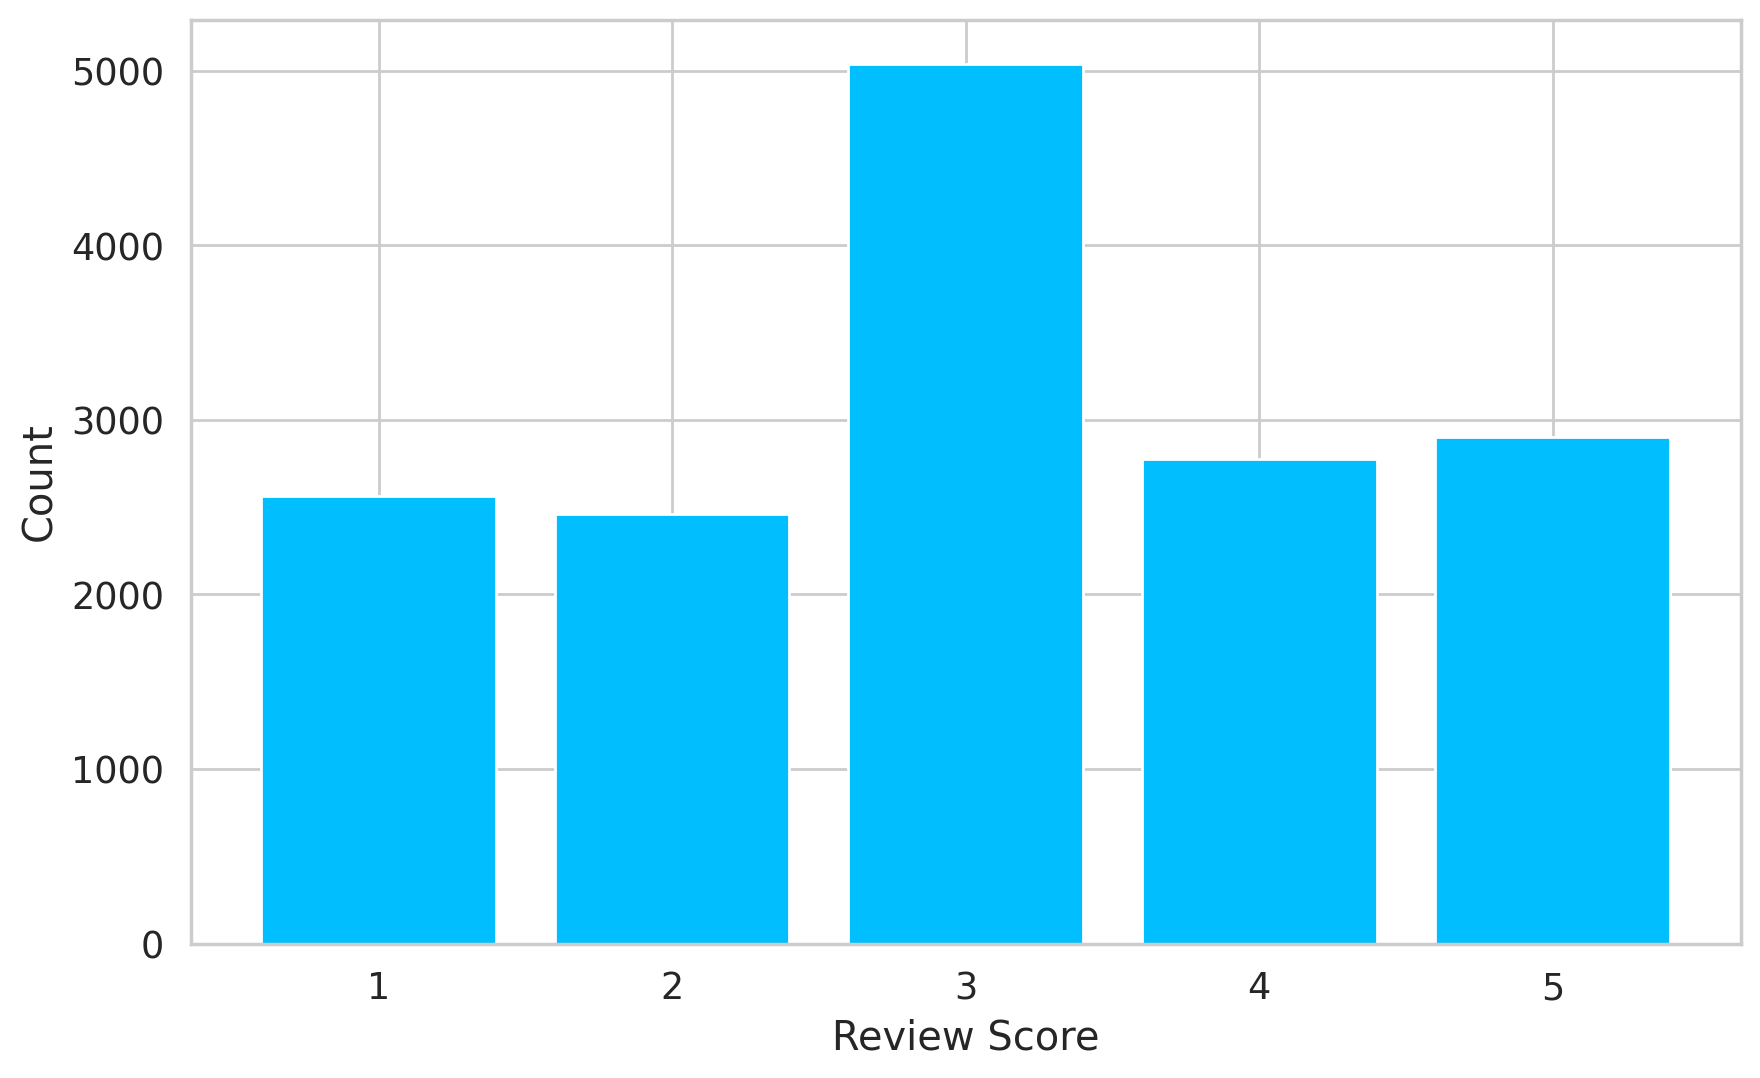

In [7]:
plt.figure(figsize=(10, 6))
plt.bar(df['score'].value_counts().index, df['score'].value_counts().values)
plt.xlabel('Review Score')
plt.ylabel('Count')

plt.tight_layout
plt.show()

In [8]:
def to_sentiment(rating):
    rating = int(rating)
    if rating <= 2:
        return 0
    elif rating == 3:
        return 1
    else:
        return 2

df['sentiment'] = df.score.apply(to_sentiment)

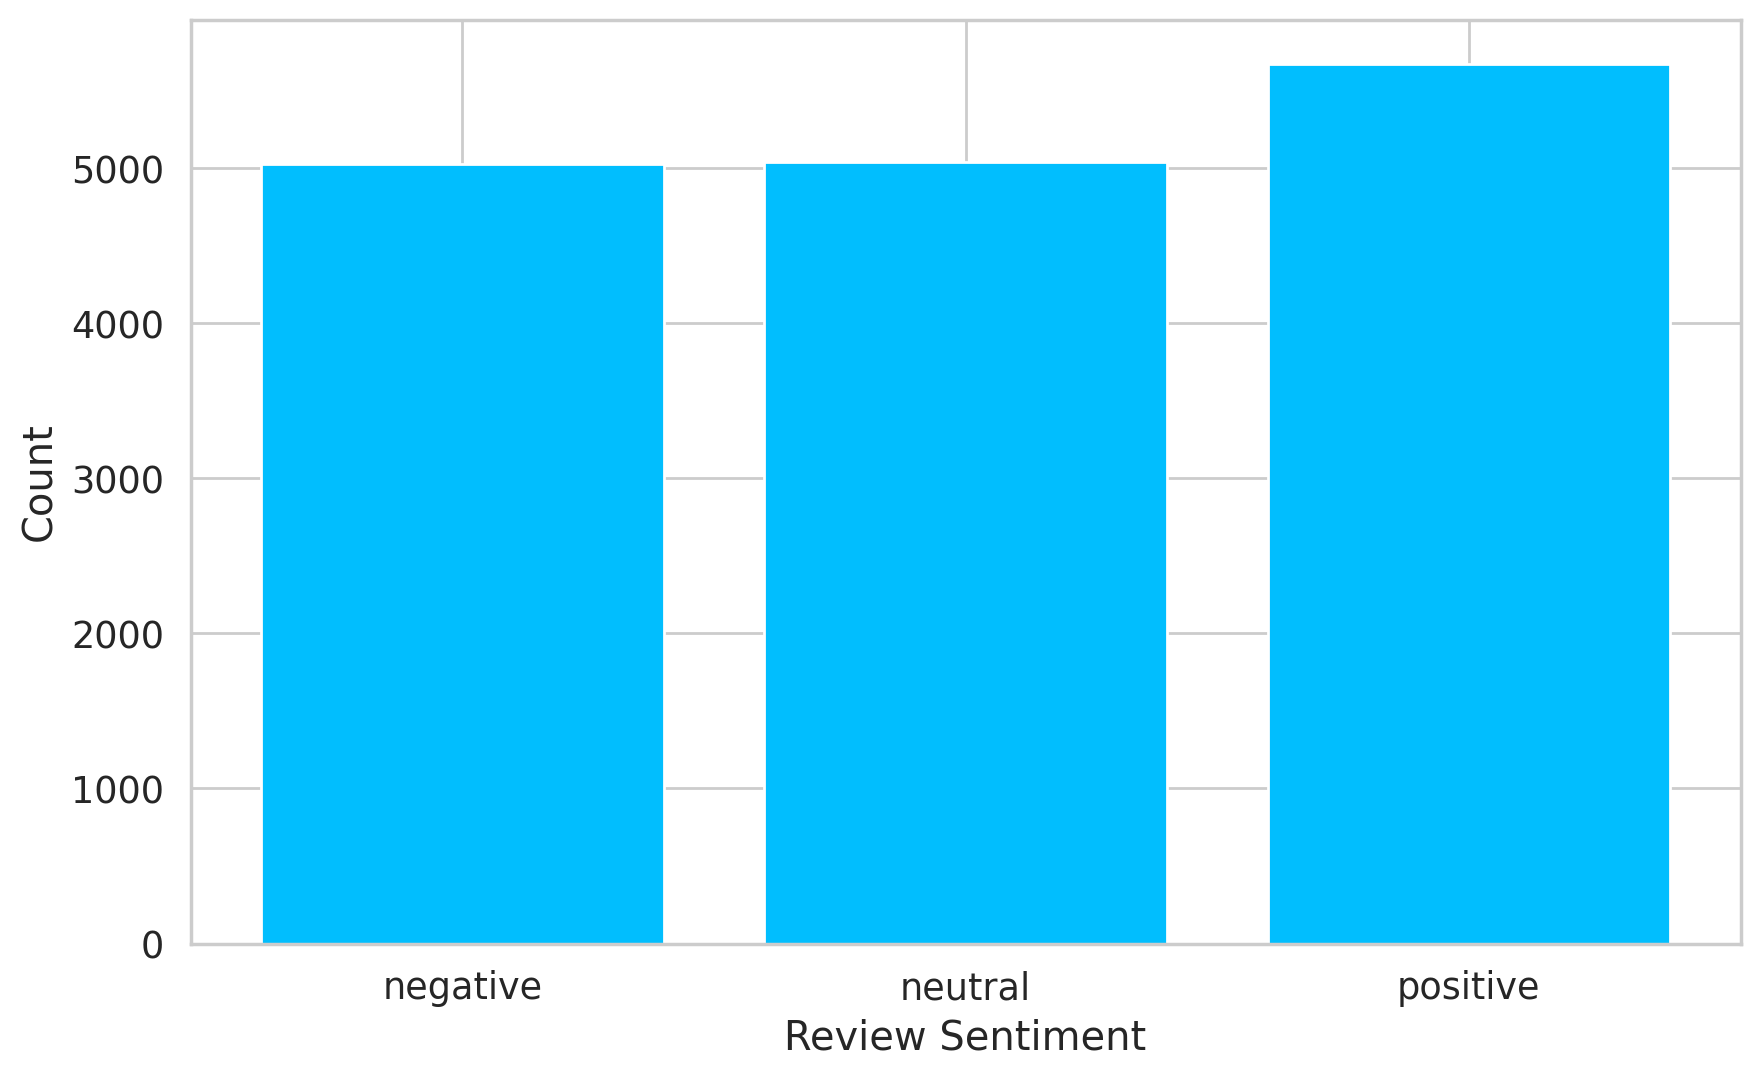

In [9]:
class_names = ['negative', 'neutral', 'positive']

plt.figure(figsize=(10, 6))
plt.bar(df['sentiment'].value_counts().index, df['sentiment'].value_counts().values)
plt.xticks(ticks=[0, 1, 2], labels=class_names)

plt.xlabel('Review Sentiment')
plt.ylabel('Count')

plt.tight_layout
plt.show()

In [10]:
pretrained_model_name = 'bert-base-cased'

In [11]:
tokenizer = BertTokenizer.from_pretrained(pretrained_model_name)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [12]:
sample_text = 'When was I last outside? I am stuck at home for 2 weeks'

# Tokenizes sample_text (tokenizer.tokenize), converts tokens to IDs

tokens = tokenizer.tokenize(sample_text)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f'Sentence: {sample_text}')
print(f'tokens: {tokens}')
print(f'token_ids: {token_ids}')

Sentence: When was I last outside? I am stuck at home for 2 weeks
tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks']
token_ids: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277]


In [13]:
bert_model = BertModel.from_pretrained(pretrained_model_name)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [14]:
tokenizer.sep_token, tokenizer.sep_token_id # illustrate the [SEP] special token.

('[SEP]', 102)

In [15]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [16]:
tokenizer.pad_token, tokenizer.pad_token_id # show what token is used for padding.

('[PAD]', 0)

In [17]:
tokenizer.unk_token, tokenizer.unk_token_id # token for unknown words.

('[UNK]', 100)

	•	Breaks your text into tokens (mostly words and sub-words) using WordPiece.
	•	Maps each token to a fixed integer ID using a vocabulary file that ships with the model.
	•	Adds special tokens ([CLS], [SEP]) that BERT expects.
	•	Pads/truncates to a fixed length so you can batch things.
	•	Builds an attention mask so the model can ignore the padded parts.

In [18]:
encoding = tokenizer(
    sample_text,
    max_length=32,
    padding='max_length',
    truncation=True,
    add_special_tokens=True,
    return_attention_mask=True,
    return_token_type_ids=False,
    return_tensors='pt',
)

In [19]:
encoding.keys()

KeysView({'input_ids': tensor([[ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
         1111,  123, 2277,  102,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])})

In [20]:
encoding['input_ids'][0]

tensor([ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
        1111,  123, 2277,  102,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [21]:
encoding['attention_mask'][0]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

In [22]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'When',
 'was',
 'I',
 'last',
 'outside',
 '?',
 'I',
 'am',
 'stuck',
 'at',
 'home',
 'for',
 '2',
 'weeks',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [23]:
# Builds token_lens by encoding each df.content (max 512) and storing lengths.
token_lens = []

for txt in df.content:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Text(0.5, 0, 'Token count')

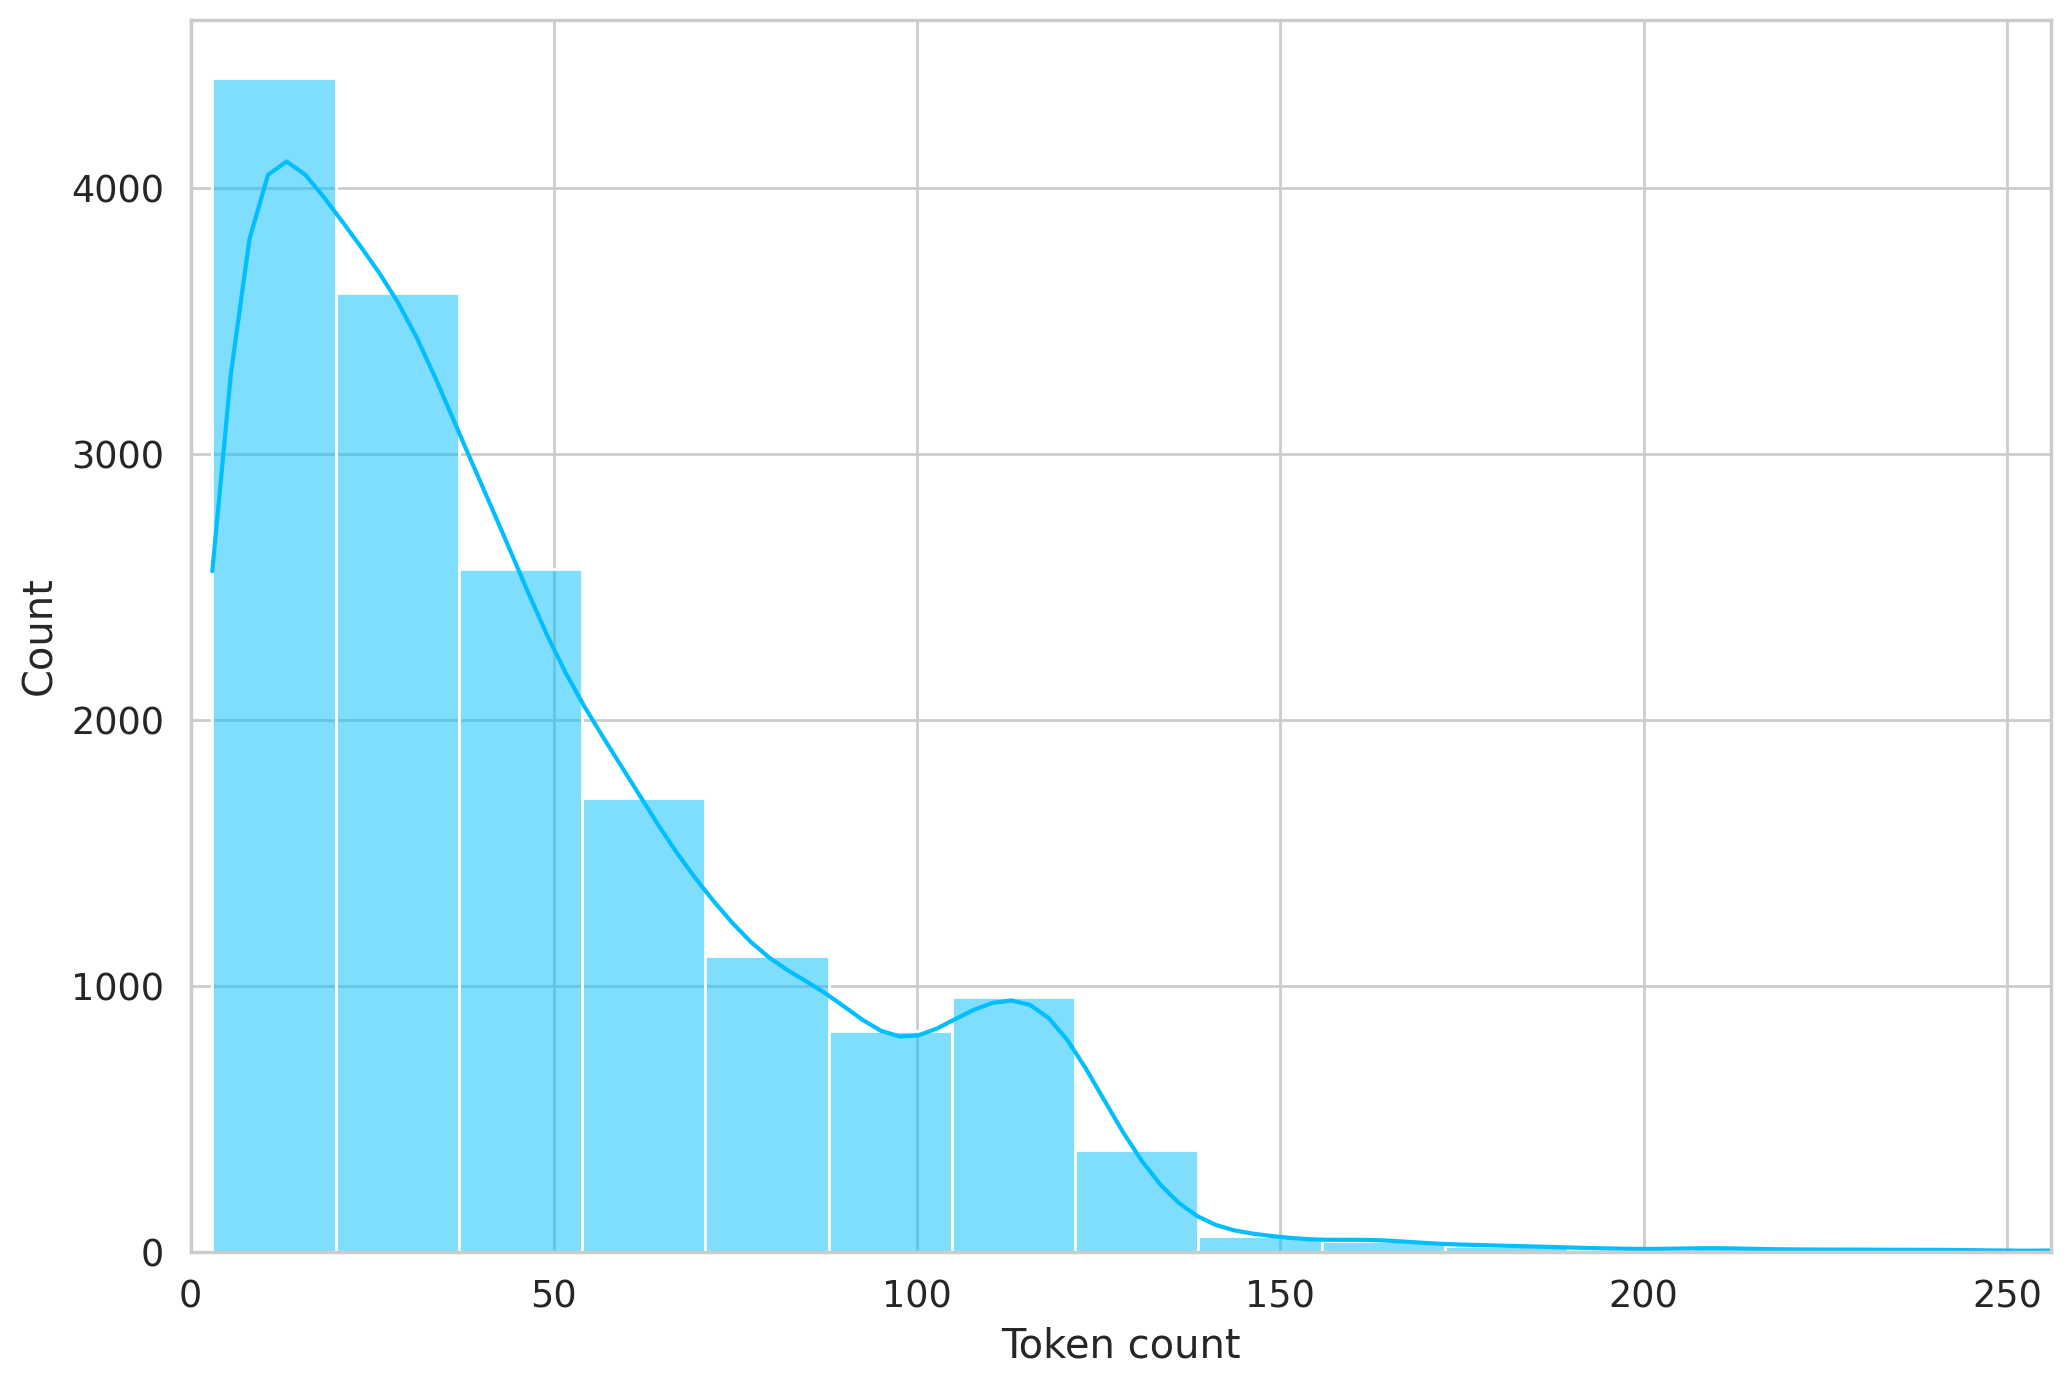

In [24]:
sns.histplot(token_lens, bins=30, kde=True)  # in the following graph “Count” means: number of texts in that bin.
plt.xlim([0, 256])
plt.xlabel('Token count')

In [25]:
class dataset_for_sentiment(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens = True,
            truncation = True,
            max_length = self.max_len,
            return_token_type_ids = False,
            padding = 'max_length',
            return_attention_mask = True,
            return_tensors = 'pt'
        )

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

In [26]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

df_train.shape, df_test.shape, df_val.shape

((14171, 12), (788, 12), (787, 12))

In [27]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = dataset_for_sentiment(
        reviews = df.content.to_numpy(),
        targets = df.sentiment.to_numpy(),
        tokenizer = tokenizer,
        max_len = max_len
    )

    return DataLoader(
        ds,
        batch_size = batch_size

    )

In [28]:
MAX_LEN = 160
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)


In [29]:
data = next(iter(train_data_loader)) # peek at one batch’s keys (input_ids, attention_mask, targets, review_text)
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [30]:
data

{'review_text': ["You can't have your to do list as notifications",
  "I haven't been using this very long and it's not as user friendly as the Calender that came on my last phone.  I wish instead of dots you can just see what you have entered for that day immediately without tapping on that day.  Otherwise it is easy to use and functional.",
  '1. Кривой и неработающий экспорт и импорт. 2. Нельзя удалить базовые навыки, заданий и характеристики. 3. Нельзя удалять сразу несколько навыков, заданий и характеристик. 4. Кнопка отчислить данные не удаляет всё, а только откатывает к базовым. Спустя пару месяцев снова установил приложение. Загрузил с автосохронерия данных - загрузилось всё базовое и с диска тоже самое (настройки тоже). Проверял после установки изменяя данные и сохраняя их потом. Итог: после загрузки зброс к базовым.',
  'Love it so far. Wish it had a widget for Android though.',
  "Liked the prioritization by dragging and the highlighting, but there does not seem to be a way 

In [31]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


In [32]:
bert_model = BertModel.from_pretrained(pretrained_model_name)

output = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)

In [33]:
last_hidden_state = output['last_hidden_state'] # embeddings for every token in your input sequence, after all transformer layers.
last_hidden_state.shape

torch.Size([1, 32, 768])

In [34]:
pooled_output = output['pooler_output'] # embedding of the [CLS] token (the first token) and passes it through a small feed-forward layer to create a single vector representing the entire sentence.
# so it is the summary of the entire sentence
pooled_output.shape

torch.Size([1, 768])

In [35]:
class SentimentClassifier(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.bert = BertModel.from_pretrained(pretrained_model_name)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        output = self.bert(input_ids, attention_mask)
        pooled_output = output['pooler_output']
        output = self.drop(pooled_output)
        output = self.out(output)
        return output

In [36]:
model = SentimentClassifier(len(class_names))

In [37]:
model.to(device) # move model to GPU

SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, eleme

In [38]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

In [39]:
# F.softmax(model(input_ids, attention_mask), dim=1) converts the model’s raw class scores (logits) into probabilities for each class along the class dimension.
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.1660, 0.1889, 0.6452],
        [0.1654, 0.2375, 0.5970],
        [0.2255, 0.3282, 0.4463],
        [0.1742, 0.1676, 0.6582],
        [0.3528, 0.3268, 0.3204],
        [0.3323, 0.2624, 0.4053],
        [0.2161, 0.2804, 0.5035],
        [0.1706, 0.3881, 0.4412],
        [0.2611, 0.2433, 0.4956],
        [0.2144, 0.2074, 0.5782],
        [0.1943, 0.2459, 0.5598],
        [0.4099, 0.2283, 0.3618],
        [0.1986, 0.3033, 0.4981],
        [0.1732, 0.2752, 0.5516],
        [0.1794, 0.3024, 0.5182],
        [0.2719, 0.2156, 0.5125]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [40]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
import torch.nn as nn

EPOCHS = 10

# Move model to device first
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [41]:
def train_epoch(model, dataloader, loss_fn, optimizer, device, scheduler, n_examples):


    model.train()
    losses = []
    correct_predictions = 0

    for d in dataloader:
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        targets = d['targets'].to(device)

        outputs = model(
            input_ids = input_ids,
            attention_mask = attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()


    return correct_predictions.double() / n_examples, np.mean(losses)




In [42]:
def eval_mode(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
                            input_ids=input_ids,
                            attention_mask=attention_mask
                            )
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [44]:
from tqdm import tqdm
import os # Import os module

history = defaultdict(list)
best_accuracy = 0
checkpoint_path = 'checkpoint.pth' # Define checkpoint file path

# Check if a checkpoint exists and load it
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_accuracy = checkpoint.get('best_accuracy', 0) # Load best_accuracy if saved
    print(f"Resuming training from epoch {start_epoch}")
else:
    start_epoch = 0

for epoch in tqdm(range(start_epoch, EPOCHS)): # Start from start_epoch
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_mode(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    # Save checkpoint after each epoch
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_accuracy': best_accuracy, # Save best_accuracy
        'history': history # Save history
    }, checkpoint_path)


    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
----------
Train loss 0.4666784097551963 accuracy 0.8193493754851457
Val   loss 0.5592992229759693 accuracy 0.8233799237611182


 10%|█         | 1/10 [06:29<58:21, 389.03s/it]

Epoch 2/10
----------
Train loss 0.292336211519833 accuracy 0.8995130901136124
Val   loss 0.5943168239295482 accuracy 0.8475222363405337


 20%|██        | 2/10 [13:39<55:06, 413.37s/it]

Epoch 3/10
----------
Train loss 0.2163022851532548 accuracy 0.9328205490085386
Val   loss 0.6900926283746958 accuracy 0.8513341804320204


 30%|███       | 3/10 [20:27<47:56, 410.91s/it]

Epoch 4/10
----------
Train loss 0.16832514896519266 accuracy 0.9506033448592196
Val   loss 0.7021501178643667 accuracy 0.8742058449809403


 40%|████      | 4/10 [27:14<40:57, 409.58s/it]

Epoch 5/10
----------
Train loss 0.13165035480360077 accuracy 0.9652812081010514
Val   loss 0.7390308430744335 accuracy 0.8716645489199493


 50%|█████     | 5/10 [33:56<33:53, 406.60s/it]

Epoch 6/10
----------
Train loss 0.11205896345367544 accuracy 0.9697974737139229
Val   loss 0.8217656632966828 accuracy 0.8716645489199493


 60%|██████    | 6/10 [40:22<26:38, 399.70s/it]

Epoch 7/10
----------
Train loss 0.10397130702844948 accuracy 0.9716322066191518
Val   loss 0.7968807504256256 accuracy 0.8691232528589581


 70%|███████   | 7/10 [47:03<20:00, 400.04s/it]

Epoch 8/10
----------
Train loss 0.09248263495322856 accuracy 0.9755133723802132
Val   loss 0.827930683089653 accuracy 0.8754764930114358


 80%|████████  | 8/10 [53:26<13:09, 394.53s/it]

Epoch 9/10
----------
Train loss 0.08201940544918637 accuracy 0.9775598052360455
Val   loss 0.8545442939881468 accuracy 0.8767471410419314


 90%|█████████ | 9/10 [1:00:40<06:46, 406.95s/it]

Epoch 10/10
----------
Train loss 0.08197486813665125 accuracy 0.9781949050878556
Val   loss 0.9733300519763725 accuracy 0.8627700127064803


100%|██████████| 10/10 [1:07:15<00:00, 403.59s/it]


In [45]:
model.load_state_dict(torch.load('best_model_state.bin', map_location=torch.device('cpu')))

<All keys matched successfully>

In [46]:
test_acc, _ = eval_mode(
    model,
    test_data_loader,
    loss_fn,
    device,
    len(df_test)
)

In [47]:
test_acc.item()

0.8870558375634517

In [48]:
def get_predictions(model, data_loader):

    model.eval()
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d['review_text']
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            targets = d['targets'].to(device)

            outputs = model(
                input_ids = input_ids,
                attention_mask = attention_mask
            )

            _, preds = torch.max(outputs, dim=1)
            probs = F.softmax(outputs, dim=1)


            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    return review_texts, predictions, prediction_probs, real_values


In [49]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [52]:
print(classification_report(y_test.cpu(), y_pred.cpu(), target_names=class_names))

AttributeError: 'list' object has no attribute 'cpu'

In [57]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [58]:
raw_text = "I am optimistic about my preparation. I believe I will do very good in the exam"

encoded_review = tokenizer.encode_plus(
    raw_text,
    max_length = MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
)

Keyword arguments {'pad_to_max_length': True} not recognized.


In [59]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {raw_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: I am optimistic about my preparation. I believe I will do very good in the exam
Sentiment  : positive
